# Text classification using Transformers

In [2]:
import tensorflow_datasets # pip install tensorflow_datasets
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Load dataset with reviews from IMDB

These reviews are classified as either negative (label 0) or positive (label 1).

In [3]:
dataset, info = tensorflow_datasets.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

## Dataset split

Get subset of the data for training and testing (5000 samples each). Convert Keras dataset to lists of strings and labels.

In [4]:
x_train = []
y_train = []

for sample, label in train_dataset.take(5000):
    x_train.append(sample.numpy())
    y_train.append(label.numpy())

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

print(x_train[0])
print(y_train[0])

x_test = []
y_test = []

for sample, label in test_dataset.take(5000):
    x_test.append(sample.numpy())
    y_test.append(label.numpy())

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print(x_test[0])
print(y_test[0])

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
0
b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of th

## Learn the vocabulary from the training data

In [5]:
max_words = 1000
max_len = 499
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_words, output_sequence_length=max_len)

vectorize_layer.adapt(x_train)

vocab = np.array(vectorize_layer.get_vocabulary())
print(vocab[:100])

['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'it' 'i' 'this' 'that'
 'br' 'was' 'as' 'with' 'for' 'but' 'movie' 'film' 'on' 'not' 'his' 'you'
 'are' 'have' 'be' 'he' 'one' 'its' 'at' 'all' 'by' 'they' 'an' 'from'
 'who' 'so' 'like' 'her' 'or' 'just' 'if' 'about' 'out' 'has' 'what'
 'some' 'there' 'good' 'more' 'very' 'when' 'my' 'she' 'no' 'even' 'would'
 'up' 'time' 'which' 'really' 'only' 'had' 'were' 'see' 'their' 'can'
 'story' 'me' 'than' 'get' 'much' 'we' 'into' 'been' 'first' 'also' 'will'
 'other' 'bad' 'do' 'people' 'great' 'well' 'because' 'most' 'how' 'dont'
 'him' 'then' 'made' 'films' 'too' 'way' 'them' 'any' 'make' 'movies']


In [12]:
print(x_train[:2])
vectorized = vectorize_layer(x_train[:2]).numpy()
print(vectorized)

[b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development w

## Preprocess dataset

Add one "class" token at the beginning of every sequence.

In [6]:
maxlen = max_len+1
vocab_size = max_words+1 # include class token

x_train_vectorized = vectorize_layer(x_train).numpy()
x_train_vectorized = np.concatenate((np.full((len(x_train_vectorized), 1), max_words, dtype=np.int64), x_train_vectorized), axis=1)
print(x_train_vectorized.shape, x_train_vectorized.dtype)

x_test_vectorized = vectorize_layer(x_test).numpy()
x_test_vectorized = np.concatenate((np.full((len(x_test_vectorized), 1), max_words, dtype=np.int64), x_test_vectorized), axis=1)
print(x_test_vectorized.shape, x_test_vectorized.dtype)

(5000, 500) int64
(5000, 500) int64


## Training an RNN using Keras

In [7]:
# source:(https://keras.io/examples/nlp/text_classification_with_transformer/)
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, flag=False, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.flag = flag

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # layer norm
        ffn_output = self.ffn(out1)  #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        if self.flag:
            return self.layernorm2(out1 + ffn_output)[:,0,:]
        else:
            return self.layernorm2(out1 + ffn_output)  # layer norm

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

embed_dim = 64  # Embedding size for each token
num_heads = 8  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

## Using Sequential API
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(maxlen, )))
model.add(tf.keras.layers.Masking(mask_value=0))
model.add(TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim))
model.add(TransformerBlock(embed_dim, num_heads, ff_dim, True))
model.add(tf.keras.layers.Dense(ff_dim, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 500)               0         
                                                                 
 token_and_position_embeddin  (None, 500, 64)          96064     
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 64)               149504    
 merBlock)                                                       
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                        

Epoch 1/20
79/79 [==============================] - 322s 4s/step - loss: 0.6936 - accuracy: 0.5104 - val_loss: 0.6923 - val_accuracy: 0.5004
Epoch 2/20
79/79 [==============================] - 321s 4s/step - loss: 0.6896 - accuracy: 0.5330 - val_loss: 0.6891 - val_accuracy: 0.5246
Epoch 3/20
79/79 [==============================] - 315s 4s/step - loss: 0.6796 - accuracy: 0.5694 - val_loss: 0.6699 - val_accuracy: 0.5656
Epoch 4/20
79/79 [==============================] - 287s 4s/step - loss: 0.6398 - accuracy: 0.6312 - val_loss: 0.5977 - val_accuracy: 0.6936
Epoch 5/20
79/79 [==============================] - 304s 4s/step - loss: 0.5474 - accuracy: 0.7296 - val_loss: 0.4884 - val_accuracy: 0.7762
Epoch 6/20
79/79 [==============================] - 297s 4s/step - loss: 0.4572 - accuracy: 0.7894 - val_loss: 0.4426 - val_accuracy: 0.7936
Epoch 7/20
79/79 [==============================] - 302s 4s/step - loss: 0.3983 - accuracy: 0.8178 - val_loss: 0.4508 - val_accuracy: 0.7848
Epoch 8/20
79

(0.0, 0.7149431824684143)

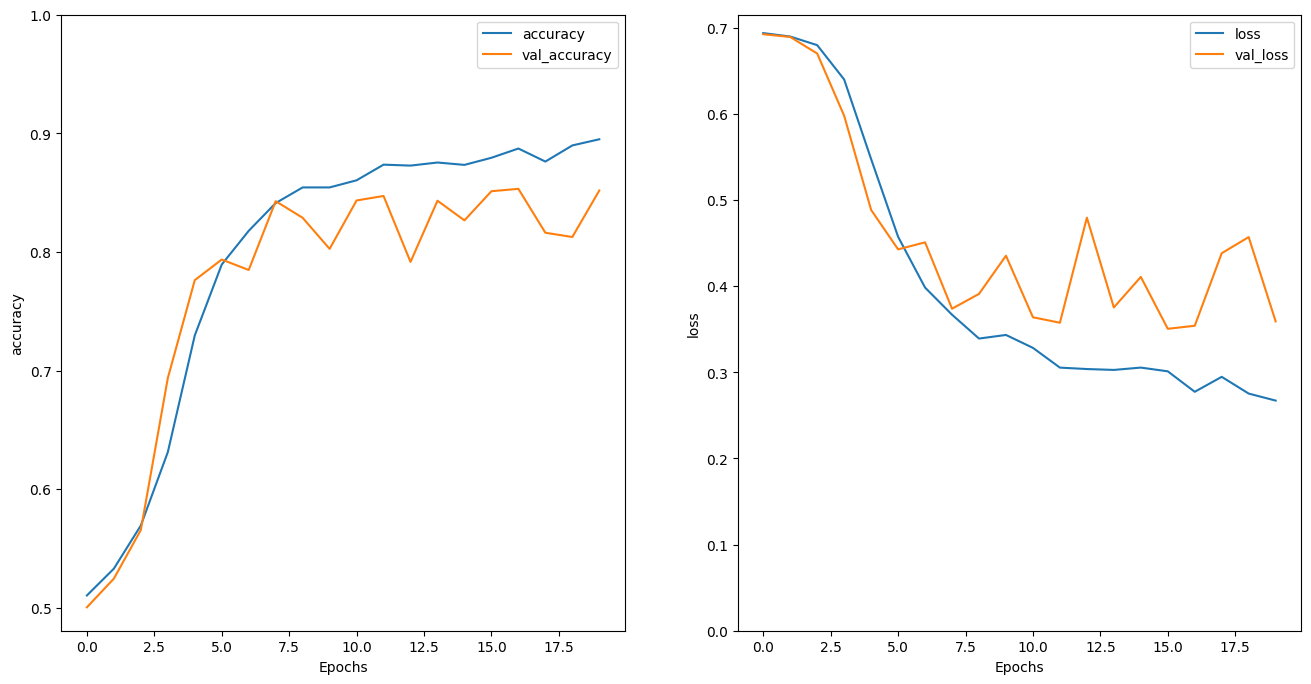

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

history = model.fit(x=x_train_vectorized, y=y_train, epochs=20, batch_size=64, validation_data=(x_test_vectorized, y_test))

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)